# DEMO_EF by Gabriel Fior

Quick demo on how to process particle collisions with Python. The goal is to determine the energy lost by the particles upon travelling though the gas detector and also evaluating the total ionization. Helpful plots will also be presented.

In [127]:
#import libraries
import numpy as np
import pandas as pd
from __future__ import print_function
#from bqplot import *
from ipywidgets import Layout
#from bqplot import pyplot as plt
from bqplot import topo_load
from bqplot.interacts import panzoom
import datetime as dt

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import files
filename = 'test_lowE_nt_B4_g_processed.csv'
df = pd.read_csv(filename,skiprows=19,header=None,
                     names=['trackId','parentId','volumeName',
                     'particleName','stepNumber','posX','posY','posZ','perp','stepLength',
                     'kineeticEnergyDiff','edepStep','kineticEnergyPostStep','processName',
                     'fCluster','particleId'])

In [3]:
#select tracks with secondaries
tracks_with_secs = df[(df.particleName!='proton')].particleId.unique()

In [4]:
df_protons_steps = df[(df.particleName=='proton')]

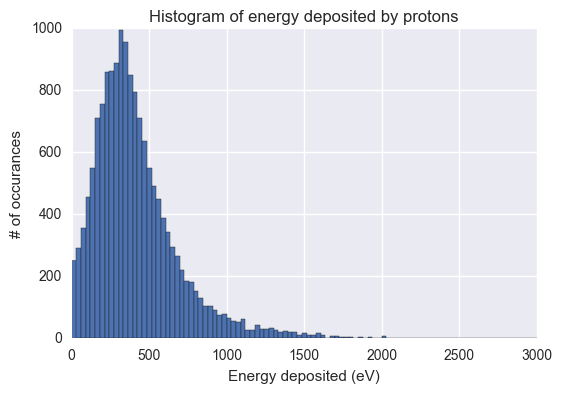

In [5]:
plt.title('Histogram of energy deposited by protons')
plt.hist(df_protons_steps.edepStep,bins=np.linspace(0,3000,100))
plt.ylabel('# of occurances')
plt.xlabel('Energy deposited (eV)')
plt.show()

But where is this energy being deposited?

Interesting is also to know the radial distribution. If it's too far away from center, energy deposited shall be neglected.

In [28]:
#Calculating posR
def get_radial_value(row):
#    return np.sqrt((np.double(row['posY'])*
#                    np.double(row['posY']))+ (np.double(row['posY'])*
#   
    return (row['posX']**2 + row['posY']**2)

def get_angle(row):
    return np.angle(row['posX'] +1j*(row['posY']),0.j + 1.0)

In [7]:
#df_protons_steps.set_index(['particleId','particleName'], inplace=True)

In [29]:
df_protons_steps['posR'] = df_protons_steps.apply(get_radial_value,axis=1)
df_protons_steps['angle'] = df_protons_steps.apply(get_angle,axis=1) 

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
df_protons_steps.head(5)

,trackId,parentId,volumeName,particleName,stepNumber,posX,posY,posZ,perp,stepLength,kineeticEnergyDiff,edepStep,kineticEnergyPostStep,processName,fCluster,particleId,posR,angle
0,1,0,Layer,proton,3,0.000118,0.000086,-7.66830,0.000146,1.33333,-320.738,320.738,199999000,Transportation,0.987373,1,2.132021e-08,36.012115
1,1,0,Layer,proton,4,0.000192,0.000144,-6.95127,0.000240,1.33333,-353.066,353.066,199999000,Transportation,0.987373,1,5.746463e-08,36.977024
2,1,0,Layer,proton,5,0.000410,0.000367,-4.84247,0.000550,1.33333,-352.191,352.191,199999000,Transportation,0.987373,1,3.030161e-07,41.882923
3,1,0,Layer,proton,6,0.000458,0.000449,-4.31959,0.000642,1.33333,-368.105,368.105,199998000,Transportation,0.987373,1,4.119490e-07,44.415536
4,1,0,Layer,proton,7,0.000694,0.000898,-2.05930,0.001135,1.33333,-633.224,633.224,199998000,Transportation,0.987373,1,1.287268e-06,52.294536


In [10]:
#sns.pairplot(df_protons_steps['edepStep'],df_protons_steps['posR'])

/Users/gabrielfior/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


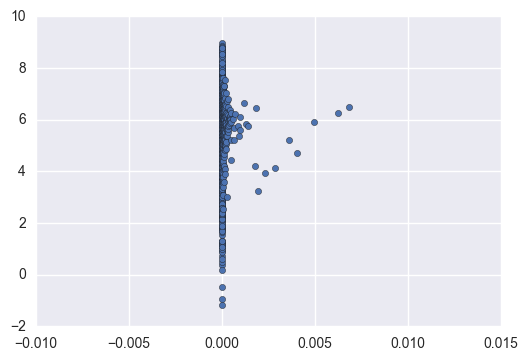

In [96]:
coordR = df_protons_steps.posR.copy()
coordR.sort()
plt.scatter(coordR,np.log(df_protons_steps.edepStep))

# Number of clusters for electron density calculation

Obtaining the energy deposit inside the plasma region (approx 2 mm away), this can be converted into electronic density by a constant (specific for a material).

In [107]:
df_deposit = df_protons_steps[df_protons_steps.posR<0.002].copy()

In [109]:
df_deposit.edepStep.sum()/26.3 #26.3 eV = value required for creation 1 electron-ion pair.
#That gives us total number of electrons

255796.52155110234

In [110]:
#Divide by volume, which is approx 2mm in radius and 10 m long
total_volume = 0.2*0.2*np.pi*10*1e2 #

In [117]:
electronic_density = df_deposit.edepStep.sum()/26.3 / total_volume
print(str(electronic_density) + ' e-/cm^3') 

2035.56404153 e-/cm^3


# Plot tracks of secondaries

In [119]:
tracks_with_secs[:10] #10 fist only
# 9 is a track with secondary

array([ 2,  5,  9, 10, 11, 16, 18, 20, 22, 24])

In [124]:
df_track_of_interest = df[df['particleId']==9]

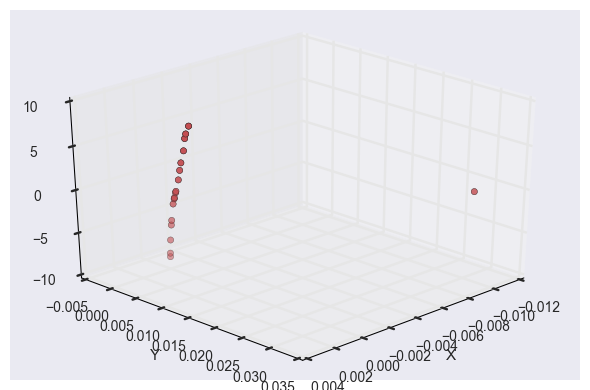

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#plt.plot(df_track_of_interest.posX)

ax.scatter(df_track_of_interest.posX, df_track_of_interest.posY, df_track_of_interest.posZ, c='r', marker='o')
ax.scatter(df_track_of_interest.posX, df_track_of_interest.posY, df_track_of_interest.posZ, c='r', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
ax.view_init(30, 45)
plt.tight_layout()
plt.show()